# Object detection Using tensorflow for Jetson Nano


In [1]:
import tensorflow as tf
import tensorflow.contrib.tensorrt as trt

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

The frozen file graph is optimized using TensorRT (Tensorflow implementation TF-TRT), function get_frozen_graph() below retrieve the frozen file load it into memory ( Warning very slow !, be patient, refer to https://jkjung-avt.github.io/tf-trt-revisited/ for info)

In [2]:
def get_frozen_graph(graph_file):
    """Read Frozen Graph file from disk."""
    with tf.gfile.GFile(graph_file, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    return graph_def

# The TensorRT inference graph file downloaded from Colab or your local machine.
pb_fname = "ssd_mobilenet_v2_coco.pb"
trt_graph = get_frozen_graph(pb_fname)

input_names = ['image_tensor']

# Create session and load graph
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_sess = tf.Session(config=tf_config)
tf.import_graph_def(trt_graph, name='')

tf_input = tf_sess.graph.get_tensor_by_name(input_names[0] + ':0')
tf_scores = tf_sess.graph.get_tensor_by_name('detection_scores:0')
tf_boxes = tf_sess.graph.get_tensor_by_name('detection_boxes:0')
tf_classes = tf_sess.graph.get_tensor_by_name('detection_classes:0')
tf_num_detections = tf_sess.graph.get_tensor_by_name('num_detections:0')

Below are just to test the image detection from a random picture

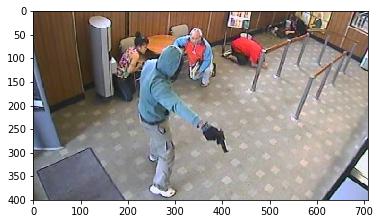

In [3]:
from PIL import Image
import matplotlib
import numpy as np
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

image = Image.open('./data/Robbery.jpg')

image_resized = np.array(image.resize((300, 300)))
image = np.array(image)
plt.imshow(image)



In [4]:
scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
    tf_input: image[None, ...]
})

boxes = boxes[0] # index by 0 to remove batch dimension
scores = scores[0]
classes = classes[0]
num_detections = num_detections[0]
num_detections

3.0

Draw boxes on all detections 

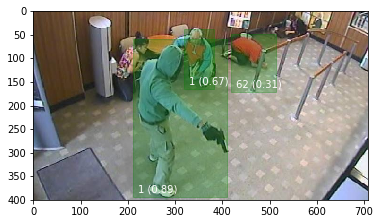

In [5]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.imshow(image)

# plot boxes exceeding score threshold
for i in range(int(num_detections)):
    # scale box to image coordinates
    box = boxes[i] * np.array([image.shape[0], image.shape[1], image.shape[0], image.shape[1]])

    # display rectangle
    patch = patches.Rectangle((box[1], box[0]), box[3] - box[1], box[2] - box[0], color='g', alpha=0.3)
    ax.add_patch(patch)

    # display class index and score
    plt.text(x=box[1] + 10, y=box[2] - 10, s='%d (%0.2f) ' % (classes[i], scores[i]), color='w')

plt.show()

Jetbot is required to create a camera instance. 

In [6]:
from jetbot import Camera, bgr8_to_jpeg
from IPython.display import display
import ipywidgets.widgets as widgets
import traitlets

In [7]:
image_widget = widgets.Image(format='jpeg', width=300, height=300)

display(image_widget)

Image(value=b'', format='jpeg', height='300', width='300')

In [8]:
camera = Camera.instance(width=300, height=300)

In [9]:
import cv2

FRAME_HEIGHT = 200
FRAME_WIDTH = 200

def load_labels(file):
    labels = ['unlabeled']
    with open(file, 'r') as f:
        for line in f.read().splitlines():
            labels.append(line)
    return labels

labels = load_labels('./data/labels.txt')

def execute(change):
    
    image = change['new']
    scores, boxes, classes, num_detections \
        = tf_sess.run( \
            [tf_scores, tf_boxes, tf_classes, tf_num_detections], \
            feed_dict={tf_input: image[None, ...]})
    
    boxes = boxes[0] # index by 0 to remove batch dimension
    scores = scores[0]
    classes = classes[0]
    num_detections = num_detections[0]
     
    
    num_labels = len(labels)
    
    for i in range(int(num_detections)):
               # Look up label string
        class_id = int(classes[i])
        label = labels[class_id] if class_id < num_labels else 'unlabeled'
        
        #get class
        #classesI = classes[i]
        
        # Get score
        score = scores[i]

        # Draw bounding box
        box = boxes[i] * np.array( \
                [FRAME_HEIGHT, FRAME_WIDTH, FRAME_HEIGHT, FRAME_WIDTH])
        box = box.astype(np.int)
        cv2.rectangle(image, \
            (box[1], box[0]), (box[3], box[2]), (0, 255, 0), 3)
            
        # Put label near bounding box
        inf = '%s: %f' % (label,score)#(label, score)
        #print(inf)
        cv2.putText(image, inf, (box[1], box[2]), \
        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 1, cv2.LINE_AA)
    
        # update image widget
        image_widget.value = bgr8_to_jpeg(image)

execute({'new': camera.value})

In [11]:
camera.unobserve_all()

In [10]:
camera.observe(execute, names='value')

In [ ]:
tf_sess.close()
